# Policy-Gradient Methods - REINFORCE Algorithm (CartPole)


## Import packages

In [10]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
import random
import time

random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

## OpenAI Gym's Cartpole Environment

In [2]:
env = gym.make('CartPole-v1')
print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('reward_threshold: ', env.spec.reward_threshold)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)
reward_threshold:  475.0


## Model

In [3]:
obs_size = env.observation_space.shape[0] 
n_actions = env.action_space.n  
HIDDEN_SIZE = 256

model = torch.nn.Sequential(
    torch.nn.Linear(obs_size, HIDDEN_SIZE),
    torch.nn.ReLU(),
    torch.nn.Linear(HIDDEN_SIZE, n_actions),
    torch.nn.Softmax(dim=1)
)

print(model)

Sequential(
  (0): Linear(in_features=4, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=2, bias=True)
  (3): Softmax(dim=1)
)


## The REINFORCE training loop

In [4]:
#---- define learning rate and gradient descent algo ----
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#---- define RL hypermarams ----

# maximum number of steps per episode
Horizon = 500

# maximum number of episodes for training phase 
MAX_TRAJECTORIES = 300

# reward discount factor
gamma = 0.99



#---- launch training phase ----
score = [] 
for trajectory in range(MAX_TRAJECTORIES):
    
    # init env
    curr_state = env.reset()
    done = False
    transitions = [] 
    
    # run one episode / trajectory
    for t in range(Horizon):
        
        # use model to transition from state(t) to state(t+1)
        act_prob = model(torch.from_numpy(curr_state.reshape((1, -1))).float())
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy()[0,:])
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) 
        transitions.append((prev_state, action, t+1)) 
        if done: 
            break
    
    # compute score (for cartpole env, reward = +1 for every step taken, including termination step)
    score.append(len(transitions))
    
    # compute batch-wise cumulative rewards
    # G(t=0) = T     (T = termination step)
    # G(t=1) = T-1
    # G(t=k) = T-k
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) 
    
    # compute batch-wise dicounted cumulative rewards (or 'gains')
    # Gg(t) = sum_{i=t}^T gamma^i * G(t=i)
    batch_Gvals =[]
    for i in range(len(transitions)):
        new_Gval=0
        power=0
        for j in range(i,len(transitions)):
            new_Gval=new_Gval+((gamma**power)*reward_batch[j]).numpy()
            power+=1
        batch_Gvals.append(new_Gval)
    expected_returns_batch=torch.FloatTensor(batch_Gvals)
    
    # normalization of gains
    expected_returns_batch /= expected_returns_batch.max()
    
    # retrieve batch-wise states and action b
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) 
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) 
    
    # compute batch-wise model preds
    pred_batch = model(state_batch)
    
    # retrieve prends of executed actions
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() 
    
    # compute loss 
    loss = - torch.sum(torch.log(prob_batch) * expected_returns_batch) 
    
    # backprop and gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # logging
    if trajectory % 50 == 0 and trajectory>0:
            print('Trajectory {}\tAverage Score: {:.2f}'.format(trajectory, np.mean(score[-50:-1])))

Trajectory 50	Average Score: 63.18
Trajectory 100	Average Score: 104.41
Trajectory 150	Average Score: 145.96
Trajectory 200	Average Score: 198.37
Trajectory 250	Average Score: 261.90


In [5]:
# prob_batch

In [6]:
# pred_batch.sum(axis=1)

## Plot the Scores

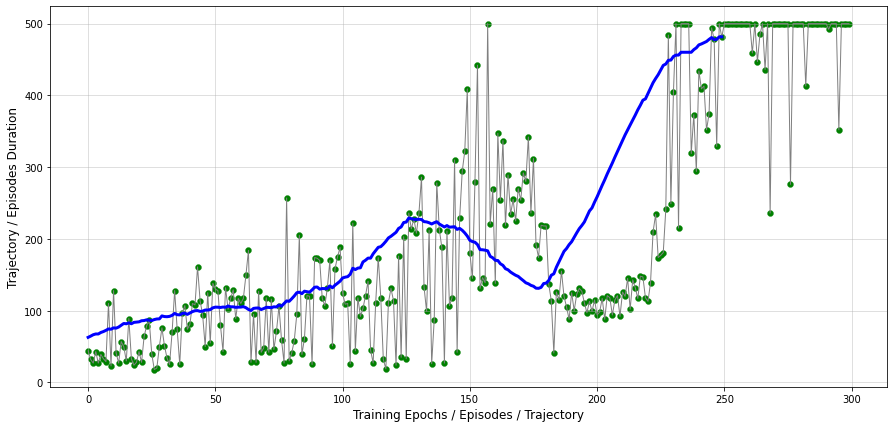

In [7]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]    # @: matrix multiplication (not elemnt-wise)
        y[i] /= N
    return y


score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory / Episodes Duration",fontsize=12)
plt.xlabel("Training Epochs / Episodes / Trajectory",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, color='green' , linewidth=0.3)
plt.grid(alpha=0.5)
plt.show()

## Render Cartpole Environment

Reward: 200.0


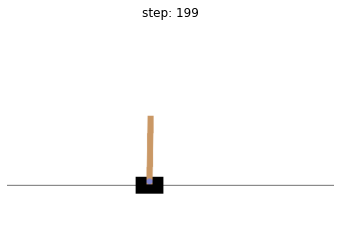

In [14]:
import pyvirtualdisplay
from IPython import display

def watch_agent():
    env = gym.make('CartPole-v0')
    state = env.reset()
    rewards = []
    img = plt.imshow(env.render(mode='rgb_array'))
    for t in range(2000):
        pred = model(torch.from_numpy(state.reshape((1,-1))).float())
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy()[0,:])

        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        plt.title(f"step: {t}")
        display.display(plt.gcf())
        display.clear_output(wait=True)

        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            print("Reward:", sum([r for r in rewards]))
            break
        time.sleep(0.05)
    env.close()

watch_agent()